In [1]:
import pandas as pd
import numpy as np

from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")

import schemas
import tools
from tools import Aggregate, Spk

# Load Data
### Settlement

In [2]:
# initialise sparkContext\
spark = Spk()

In [27]:
 # to read parquet file
settlement = spark.load_parquet("data/ITU_DATA/settlement/2019.parquet", schemas.settlement_schema)
settlement = settlement.dropna(subset =["VAERDI"]).withColumn("VAERDI", settlement["VAERDI"].cast("float"))
            # .where("TIME_CET like '%:00:%'")
settlement.persist()
settlement.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- VAERDI: float (nullable = true)
 |-- TIME_CET: string (nullable = true)



### Weather
from ENetNEA, wind speed, wind direction

In [4]:
ws10_dic = spark.load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_10m.parquet")
ws100_dic = spark.load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_100m.parquet")
wd10_dic = spark.load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_10m.parquet")
wd100_dic = spark.load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_100m.parquet")

In [5]:
aggs = Aggregate(ws10_dic, ws100_dic, wd10_dic, wd100_dic)

## Windmills

In [6]:
windmill = spark.load_windmill("data/windmill_cleaned.csv", schemas.windmills_schema)
windmill = windmill.where("grid != 0").fillna(0)
windmill.persist()
windmill.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- Turbine_type: string (nullable = true)
 |-- Parent_GSRN: string (nullable = true)
 |-- BBR_municipal: string (nullable = true)
 |-- Placement: string (nullable = true)
 |-- UTM_x: string (nullable = true)
 |-- UTM_y: string (nullable = true)
 |-- Capacity_kw: float (nullable = false)
 |-- Rotor_diameter: float (nullable = false)
 |-- Navhub_height: float (nullable = false)
 |-- grid: string (nullable = true)
 |-- grid_in_range: string (nullable = true)
 |-- Land_cover: float (nullable = false)
 |-- Slope: float (nullable = false)
 |-- roughness: float (nullable = false)



# Upscaling by grid

In [7]:
feat_cols = ["GSRN", "Turbine_type", "Slope", "roughness", "grid"]
windmill_W = windmill.select(feat_cols).where("Turbine_type != 'W'")
windmill_W.count()

3438

In [28]:
train = settlement.where("TIME_CET not like '2019-03-31 02%'").where("TIME_CET not like '2019-12-30%'") \
        .sample(fraction=0.0003, seed=5)
train = aggs.aggregate_with_upscaling(train, windmill_W)
train.persist()

DataFrame[TIME_CET: string, grid: string, Slope: double, roughness: double, VAERDI: double, month: int, hour: int, ws10: float, ws100: float, wd10: int, wd100: int]

In [9]:
train.count()

e "<ipython-input-9-f0887af494dd>", line 1, in <module>
    train.count()
  File "/usr/local/lib/python3.7/site-packages/pyspark/sql/dataframe.py", line 523, in count
    return int(self._jdf.count())
  File "/usr/local/lib/python3.7/site-packages/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/lib/python3.7/site-packages/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.7/site-packages/py4j/protocol.py", line 328, in get_return_value
    format(target_id, ".", name), value)
py4j.protocol.Py4JJavaError: <unprintable Py4JJavaError object>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception oc

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:62878)

In [29]:
test = settlement.where("TIME_CET like '2019-12-30%'")
test = aggs.aggregate_with_upscaling(test, windmill_W)

In [10]:
test.count()

9960

# pyTorch

In [11]:
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
dtype = torch.float

In [30]:
train_pd = train.toPandas()

In [31]:
test_pd = test.toPandas()

In [32]:
test_pd.head(2)

,TIME_CET,grid,Slope,roughness,VAERDI,month,hour,ws10,ws100,wd10,wd100
0,2019-12-30 02:00:00,1281,2.38195,0.133333,2330.000000,12,2,7.5,13.3,235,236
1,2019-12-30 12:30:00,1069,0.00000,0.100000,228.800003,12,12,8.2,13.1,250,252


In [117]:
feat_cols = ["month", "hour", "Slope", "roughness","ws10", "ws100","wd10","wd100"]
x_train = train_pd[feat_cols]
y_train = train_pd[["VAERDI"]]
x_test = test_pd[feat_cols]
y_test = test_pd[["VAERDI"]]
timeline = test_pd[["TIME_CET"]]

In [118]:
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [119]:
x_train_tensor = torch.tensor(x_train, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)

y_train_tensor = torch.tensor(y_train.values, dtype = dtype)
y_test_tensor = torch.tensor(y_test.values, dtype = dtype)

In [120]:
x_train_tensor.shape, y_train_tensor.shape

(torch.Size([4562, 8]), torch.Size([4562, 1]))

In [121]:
input_size = 8
output_size = 1
hidden_size = 300

In [122]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = self.fc3(x)

    return x

In [123]:
model = Net()

In [124]:
optimizer = optim.Adam(model.parameters(),lr=0.25)

# nn.MSELoss() is implemented by default as: ((input-target)**2).mean()
loss_fn = torch.nn.MSELoss()

In [125]:
epoch_data = []
epochs = 2001

for epoch in range(1, epochs):
  optimizer.zero_grad()
  y_pred = model(x_train_tensor)

  loss = loss_fn(y_pred, y_train_tensor)
  loss.backward()

  optimizer.step()

#   _,pred = y_pred_test.data.max(1)

#   accuracy = pred.eq(y_test_tensor.data).sum().item() / y_test.values.size
#   epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])

  if epoch % 100 == 0:
    print('epoch -%d (%d%%) train loss - %.2f ' \
          % (epoch, epoch/203, loss.data.item()))

epoch -100 (0%) train loss - 25958356.00 
epoch -200 (0%) train loss - 22302202.00 
epoch -300 (1%) train loss - 19691590.00 
epoch -400 (1%) train loss - 17091418.00 
epoch -500 (2%) train loss - 14183534.00 
epoch -600 (2%) train loss - 11451267.00 
epoch -700 (3%) train loss - 9212656.00 
epoch -800 (3%) train loss - 8204160.50 
epoch -900 (4%) train loss - 7629592.00 
epoch -1000 (4%) train loss - 6761259.00 
epoch -1100 (5%) train loss - 5956438.50 
epoch -1200 (5%) train loss - 8009457.50 
epoch -1300 (6%) train loss - 8441593.00 
epoch -1400 (6%) train loss - 7178367.00 
epoch -1500 (7%) train loss - 6263107.00 
epoch -1600 (7%) train loss - 5352032.50 
epoch -1700 (8%) train loss - 5443093.00 
epoch -1800 (8%) train loss - 6639094.50 
epoch -1900 (9%) train loss - 5975279.50 
epoch -2000 (9%) train loss - 5173532.00 


In [126]:
y_pred_tensor = model(x_test_tensor)
y_pred = y_pred_tensor.detach().numpy()
y_test["pred"] = pd.Series(y_pred.tolist()).apply(lambda x: x[0])
y_test["time"] = pd.Series(timeline["TIME_CET"])
y_test = y_test.groupby(y_test["time"]).agg({"VAERDI":lambda x:sum(x), "pred":lambda x:sum(x)}).reset_index()

In [127]:
y_test

,time,VAERDI,pred
0,2019-12-30 00:00:00,744338.482775,374239.282013
1,2019-12-30 00:15:00,683976.674130,337563.251358
2,2019-12-30 00:30:00,682976.156108,337563.251358
3,2019-12-30 00:45:00,681903.005729,337563.251358
4,2019-12-30 01:00:00,738946.538215,454836.282043
...,...,...,...
91,2019-12-30 22:45:00,510015.601939,63950.934540
92,2019-12-30 23:00:00,700797.536448,68068.964783
93,2019-12-30 23:15:00,628517.499259,65054.363159
94,2019-12-30 23:30:00,628443.942110,65054.363159


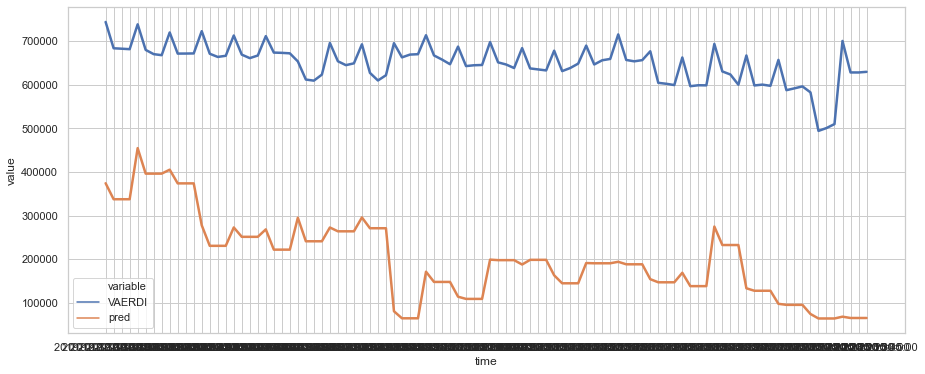

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(y_test, ['time']), hue='variable',linewidth=2.5)